# Cone FEM vs SMS Comparison Slice Viewer

## Notebook Overview

This notebook contains multiple visualizations:

1. **FEM vs SMS Comparison** - Compare FEM and SMS displacement results with color-coded overlay
2. **Error Visualization** - View displacement errors between FEM and SMS solutions
3. **Parameter Viewer** - View material parameters (alpha, beta, kappa) slice by slice
4. **Convergence Analysis** - 




In [13]:
from pathlib import Path
import os
import numpy as np
import meshio
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib.tri as mtri
import json
import matplotlib.pyplot as plt
import pandas as pd
os.getcwd()

'/home/haozhe/Lung_Mesh_Segment/toy_verification/hetero_verification'

---

## FEM vs SMS 
### Displacement Comparison

Interactive slice viewer comparing FEM and SMS displacement results across x, y, z axes simultaneously.


In [14]:
def load_comparison_data(fem_path: Path, sms_path: Path):
    """
    Load FEM and SMS mesh data for comparison.
    
    Args:
        fem_path: Path to FEM reference mesh
        sms_path: Path to SMS solution mesh
        
    Returns:
        Tuple of (points_fem, cells, labels, disp_fem, points_sms, disp_sms)
    """
    # Load FEM mesh
    fem_mesh = meshio.read(fem_path)
    points_fem = fem_mesh.points.astype(np.float64)
    cells = fem_mesh.cells[0].data.astype(np.int32)
    
    # Get labels
    if "labels" in fem_mesh.cell_data:
        labels = np.asarray(fem_mesh.cell_data["labels"][0]).astype(np.int32)
    else:
        labels = None
    
    # Load SMS mesh
    sms_mesh = meshio.read(sms_path)
    points_sms = sms_mesh.points.astype(np.float64)
    
    # Compute displacements by loading initial mesh
    initial_path = fem_path.parent / "cone_sms_solution_initial.xdmf"
    initial_mesh = meshio.read(initial_path)
    points_initial = initial_mesh.points.astype(np.float64)
    
    disp_fem = points_fem - points_initial
    disp_sms = points_sms - points_initial
    
    print(f"Loaded FEM: {points_fem.shape[0]} nodes, {cells.shape[0]} tets")
    print(f"Loaded SMS: {points_sms.shape[0]} nodes, {cells.shape[0]} tets")
    print(f"FEM displacement range: [{np.linalg.norm(disp_fem, axis=1).min():.6e}, {np.linalg.norm(disp_fem, axis=1).max():.6e}]")
    print(f"SMS displacement range: [{np.linalg.norm(disp_sms, axis=1).min():.6e}, {np.linalg.norm(disp_sms, axis=1).max():.6e}]")
    
    return points_fem, cells, labels, disp_fem, points_sms, disp_sms


def render_comparison_three_axes(layer_index: int, slices: int, component: str, label_value,
                                  points_fem, cells, labels, disp_fem, points_sms, disp_sms):
    """
    Render FEM vs SMS comparison across x, y, z axes in a single figure.
    
    Args:
        layer_index: Current slice index
        slices: Total number of slices
        component: Displacement component to visualize ('x', 'y', 'z', 'magnitude')
        label_value: Label filter ('all' or specific label)
        points_fem: FEM mesh points
        cells: Tetrahedron connectivity
        labels: Cell labels
        disp_fem: FEM displacement field
        points_sms: SMS mesh points
        disp_sms: SMS displacement field
    """
    # Compute centroids for slicing
    centroids_fem = points_fem[cells].mean(axis=1)
    
    # Extract component values
    if component == 'magnitude':
        fem_values = np.linalg.norm(disp_fem, axis=1)
        sms_values = np.linalg.norm(disp_sms, axis=1)
        component_label = "|u|"
    elif component == 'x':
        fem_values = disp_fem[:, 0]
        sms_values = disp_sms[:, 0]
        component_label = "u_x"
    elif component == 'y':
        fem_values = disp_fem[:, 1]
        sms_values = disp_sms[:, 1]
        component_label = "u_y"
    else:  # z
        fem_values = disp_fem[:, 2]
        sms_values = disp_sms[:, 2]
        component_label = "u_z"
    
    # Map nodal values to cell values (average)
    fem_cell_values = fem_values[cells].mean(axis=1)
    sms_cell_values = sms_values[cells].mean(axis=1)
    
    # Create figure with 3 columns (x, y, z slices)
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)
    
    axes_info = [
        {"name": "x", "axis_idx": 0, "plane_indices": (1, 2), "plane_labels": ("y", "z")},
        {"name": "y", "axis_idx": 1, "plane_indices": (0, 2), "plane_labels": ("x", "z")},
        {"name": "z", "axis_idx": 2, "plane_indices": (0, 1), "plane_labels": ("x", "y")},
    ]
    
    slices = max(int(slices), 1)
    layer_index = int(np.clip(layer_index, 0, slices - 1))
    
    for col_idx, info in enumerate(axes_info):
        ax = axes[col_idx]
        axis_idx = info["axis_idx"]
        plane_i, plane_j = info["plane_indices"]
        
        # Compute slice bounds
        coords = centroids_fem[:, axis_idx]
        coord_min, coord_max = float(coords.min()), float(coords.max())
        edges = np.linspace(coord_min, coord_max, slices + 1)
        lower, upper = edges[layer_index], edges[layer_index + 1]
        
        # Filter cells in slice
        mask = (coords >= lower) & (coords < upper)
        if label_value != "all" and labels is not None:
            mask &= labels == int(label_value)
        
        tet_ids = np.where(mask)[0]
        
        if tet_ids.size == 0:
            ax.text(0.5, 0.5, "No tetrahedra in this slice", ha="center", va="center", fontsize=12)
            ax.set_axis_off()
            continue
        
        # Project points onto 2D plane
        projected_fem = points_fem[:, [plane_i, plane_j]]
        projected_sms = points_sms[:, [plane_i, plane_j]]
        
        # Create triangulated faces
        faces = np.array([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]], dtype=int)
        
        # Build triangulation for FEM (use as base for both)
        triangles_fem = []
        tri_fem_values = []
        
        for tet_idx in tet_ids:
            nodes = cells[tet_idx]
            value_fem = fem_cell_values[tet_idx]
            for face in faces:
                triangles_fem.append(nodes[face])
                tri_fem_values.append(value_fem)
        
        # Build triangulation for SMS with same topology
        triangles_sms = []
        tri_sms_values = []
        
        for tet_idx in tet_ids:
            nodes = cells[tet_idx]
            value_sms = sms_cell_values[tet_idx]
            for face in faces:
                triangles_sms.append(nodes[face])
                tri_sms_values.append(value_sms)
        
        # Determine common color scale
        all_values = np.concatenate([tri_fem_values, tri_sms_values])
        vmin, vmax = float(np.min(all_values)), float(np.max(all_values))
        
        # Plot FEM with solid color
        triang_fem = mtri.Triangulation(
            projected_fem[:, 0],
            projected_fem[:, 1],
            np.asarray(triangles_fem, dtype=int),
        )
        
        # Plot SMS with edge overlay
        triang_sms = mtri.Triangulation(
            projected_sms[:, 0],
            projected_sms[:, 1],
            np.asarray(triangles_sms, dtype=int),
        )
        
        # FEM: blue edges
        ax.triplot(
            triang_fem,
            color='blue',
            linewidth=1.5,
            alpha=0.7,
            label='FEM'
        )
        
        # SMS: red edges  
        ax.triplot(
            triang_sms,
            color='red',
            linewidth=1.5,
            alpha=0.7,
            label='SMS'
        )
        
        ax.set_xlabel(info["plane_labels"][0], fontsize=10)
        ax.set_ylabel(info["plane_labels"][1], fontsize=10)
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(
            f"{component_label} | {info['name']}-slice {layer_index + 1}/{slices}\n"
            f"Range [{lower:.4f}, {upper:.4f}]",
            fontsize=11
        )
        
        # Add legend
        ax.legend(loc='upper right', fontsize=9)
    

    display(fig)
    plt.close(fig)


In [15]:
def create_comparison_viewer(fem_path: Path, sms_path: Path):
    """
    Create interactive FEM vs SMS comparison viewer with x, y, z slices.
    
    Args:
        fem_path: Path to FEM reference mesh
        sms_path: Path to SMS solution mesh
    """
    # Load data
    points_fem, cells, labels, disp_fem, points_sms, disp_sms = load_comparison_data(fem_path, sms_path)
    
    # Create widgets
    slice_count_widget = widgets.IntSlider(value=20, min=5, max=120, step=1, description="Slices")
    layer_index_widget = widgets.IntSlider(value=10, min=0, max=slice_count_widget.value - 1, step=1, description="Layer")
    
    component_widget = widgets.Dropdown(
        options=['magnitude', 'x', 'y', 'z'],
        value='magnitude',
        description="Component"
    )
    
    # Label filter
    label_options = [("All labels", "all")]
    if labels is not None:
        label_options += [(f"Label {int(val)}", int(val)) for val in np.unique(labels)]
    label_widget = widgets.Dropdown(options=label_options, value=label_options[0][1], description="Label")
    
    # Update layer index range when slice count changes
    def update_layer_range(*args):
        layer_index_widget.max = slice_count_widget.value - 1
        layer_index_widget.value = min(layer_index_widget.value, layer_index_widget.max)
    
    slice_count_widget.observe(update_layer_range, 'value')
    
    # Create UI layout
    controls = widgets.VBox([
        widgets.HBox([component_widget, label_widget]),
        widgets.HBox([slice_count_widget, layer_index_widget]),
    ])
    
    # Create output
    output = widgets.interactive_output(
        render_comparison_three_axes,
        {
            "layer_index": layer_index_widget,
            "slices": slice_count_widget,
            "component": component_widget,
            "label_value": label_widget,
            "points_fem": widgets.fixed(points_fem),
            "cells": widgets.fixed(cells),
            "labels": widgets.fixed(labels),
            "disp_fem": widgets.fixed(disp_fem),
            "points_sms": widgets.fixed(points_sms),
            "disp_sms": widgets.fixed(disp_sms),
        },
    )
    
    display(controls, output)


In [ ]:
# Load FEM and SMS comparison viewer
xdmf_dir = Path("results/xdmf_visualization")
fem_path = xdmf_dir / "cone_sms_solution_fem_reference.xdmf"
sms_path = xdmf_dir / "cone_sms_solution_sms_solution.xdmf"

create_comparison_viewer(fem_path, sms_path)


Loaded FEM: 1829 nodes, 8070 tets
Loaded SMS: 1829 nodes, 8070 tets
FEM displacement range: [0.000000e+00, 5.723639e-02]
SMS displacement range: [0.000000e+00, 5.503036e-02]


### Displacement Error Visualization

View the difference between FEM and SMS results to identify regions with high discrepancy.


In [ ]:
def render_error_three_axes(layer_index: int, slices: int, error_type: str, label_value,
                            points_fem, cells, labels, disp_fem, points_sms, disp_sms):
    """
    Render displacement error across x, y, z axes in a single figure.
    
    Args:
        layer_index: Current slice index
        slices: Total number of slices
        error_type: Type of error ('absolute', 'relative', 'x_error', 'y_error', 'z_error')
        label_value: Label filter ('all' or specific label)
        points_fem: FEM mesh points
        cells: Tetrahedron connectivity
        labels: Cell labels
        disp_fem: FEM displacement field
        points_sms: SMS mesh points
        disp_sms: SMS displacement field
    """
    # Compute centroids for slicing (use FEM positions as reference)
    centroids_fem = points_fem[cells].mean(axis=1)
    
    # Compute error
    error_nodal = disp_sms - disp_fem
    
    # Extract error values
    if error_type == 'absolute':
        error_values = np.linalg.norm(error_nodal, axis=1)
        error_label = "|u_SMS - u_FEM|"
        cmap_name = 'hot'
    elif error_type == 'relative':
        fem_mag = np.linalg.norm(disp_fem, axis=1)
        error_mag = np.linalg.norm(error_nodal, axis=1)
        error_values = np.divide(error_mag, fem_mag, out=np.zeros_like(error_mag), where=fem_mag>1e-10)
        error_label = "|u_SMS - u_FEM| / |u_FEM|"
        cmap_name = 'hot'
    else:  # z_error
        error_values = error_nodal[:, 2]
        error_label = "u_SMS_z - u_FEM_z"
        cmap_name = 'RdBu_r'
    
    # Map nodal values to cell values (average)
    error_cell_values = error_values[cells].mean(axis=1)
    
    # Create figure with 3 columns (x, y, z slices)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    
    axes_info = [
        {"name": "x", "axis_idx": 0, "plane_indices": (1, 2), "plane_labels": ("y", "z")},
        {"name": "y", "axis_idx": 1, "plane_indices": (0, 2), "plane_labels": ("x", "z")},
        {"name": "z", "axis_idx": 2, "plane_indices": (0, 1), "plane_labels": ("x", "y")},
    ]
    
    slices = max(int(slices), 1)
    layer_index = int(np.clip(layer_index, 0, slices - 1))
    
    # Determine global color scale
    all_error_values = error_cell_values
    if error_type in ['x_error', 'y_error', 'z_error']:
        # Symmetric scale for signed errors
        abs_max = max(abs(all_error_values.min()), abs(all_error_values.max()))
        vmin, vmax = -abs_max, abs_max
    else:
        # Non-negative scale for magnitude errors
        vmin, vmax = 0.0, all_error_values.max()
    
    for col_idx, info in enumerate(axes_info):
        ax = axes[col_idx]
        axis_idx = info["axis_idx"]
        plane_i, plane_j = info["plane_indices"]
        
        # Compute slice bounds
        coords = centroids_fem[:, axis_idx]
        coord_min, coord_max = float(coords.min()), float(coords.max())
        edges = np.linspace(coord_min, coord_max, slices + 1)
        lower, upper = edges[layer_index], edges[layer_index + 1]
        
        # Filter cells in slice
        mask = (coords >= lower) & (coords < upper)
        if label_value != "all" and labels is not None:
            mask &= labels == int(label_value)
        
        tet_ids = np.where(mask)[0]
        
        if tet_ids.size == 0:
            ax.text(0.5, 0.5, "No tetrahedra in this slice", ha="center", va="center", fontsize=12)
            ax.set_axis_off()
            continue
        
        # Project points onto 2D plane
        projected = points_fem[:, [plane_i, plane_j]]
        
        # Create triangulated faces
        faces = np.array([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]], dtype=int)
        
        # Build triangulation
        triangles = []
        tri_error_values = []
        
        for tet_idx in tet_ids:
            nodes = cells[tet_idx]
            value = error_cell_values[tet_idx]
            for face in faces:
                triangles.append(nodes[face])
                tri_error_values.append(value)
        
        # Create triangulation
        triang = mtri.Triangulation(
            projected[:, 0],
            projected[:, 1],
            np.asarray(triangles, dtype=int),
        )
        
        # Plot error field
        collection = ax.tripcolor(
            triang,
            facecolors=np.asarray(tri_error_values, dtype=float),
            cmap=cmap_name,
            shading="flat",
            vmin=vmin,
            vmax=vmax,
        )
        
        ax.set_xlabel(info["plane_labels"][0], fontsize=10)
        ax.set_ylabel(info["plane_labels"][1], fontsize=10)
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(
            f"{error_label} | {info['name']}-slice {layer_index + 1}/{slices}\n"
            f"Range [{lower:.4f}, {upper:.4f}]",
            fontsize=11
        )
        
        # Add error statistics for this slice
        slice_errors = np.array(tri_error_values)
        stats_text = (
            f"min={slice_errors.min():.3e}\n"
            f"mean={slice_errors.mean():.3e}\n"
            f"max={slice_errors.max():.3e}"
        )
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Add shared colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.04)
    cbar.set_label(error_label, fontsize=10)
    
    display(fig)
    plt.close(fig)


def create_error_viewer(fem_path: Path, sms_path: Path):
    """
    Create interactive error visualization viewer.
    
    Args:
        fem_path: Path to FEM reference mesh
        sms_path: Path to SMS solution mesh
    """
    # Load data (reuse same loading function)
    points_fem, cells, labels, disp_fem, points_sms, disp_sms = load_comparison_data(fem_path, sms_path)
    
    # Create widgets
    slice_count_widget = widgets.IntSlider(value=20, min=5, max=120, step=1, description="Slices")
    layer_index_widget = widgets.IntSlider(value=10, min=0, max=slice_count_widget.value - 1, step=1, description="Layer")
    
    error_type_widget = widgets.Dropdown(
        options=[
            ('Absolute error magnitude', 'absolute'),
            ('Relative error', 'relative')
        ],
        value='absolute',
        description="Error type"
    )
    
    # Label filter
    label_options = [("All labels", "all")]
    if labels is not None:
        label_options += [(f"Label {int(val)}", int(val)) for val in np.unique(labels)]
    label_widget = widgets.Dropdown(options=label_options, value=label_options[0][1], description="Label")
    
    # Update layer index range when slice count changes
    def update_layer_range(*args):
        layer_index_widget.max = slice_count_widget.value - 1
        layer_index_widget.value = min(layer_index_widget.value, layer_index_widget.max)
    
    slice_count_widget.observe(update_layer_range, 'value')
    
    # Create UI layout
    controls = widgets.VBox([
        widgets.HBox([error_type_widget, label_widget]),
        widgets.HBox([slice_count_widget, layer_index_widget]),
    ])
    
    # Create output
    output = widgets.interactive_output(
        render_error_three_axes,
        {
            "layer_index": layer_index_widget,
            "slices": slice_count_widget,
            "error_type": error_type_widget,
            "label_value": label_widget,
            "points_fem": widgets.fixed(points_fem),
            "cells": widgets.fixed(cells),
            "labels": widgets.fixed(labels),
            "disp_fem": widgets.fixed(disp_fem),
            "points_sms": widgets.fixed(points_sms),
            "disp_sms": widgets.fixed(disp_sms),
        },
    )
    
    display(controls, output)


In [ ]:
# Display error visualization
create_error_viewer(fem_path, sms_path)


Loaded FEM: 1829 nodes, 8070 tets
Loaded SMS: 1829 nodes, 8070 tets
FEM displacement range: [0.000000e+00, 5.723639e-02]
SMS displacement range: [0.000000e+00, 5.503036e-02]


Output()

---

## Material Parameter Viewer

View initial or optimized material parameters (alpha, beta, kappa) from inverse problem.


In [ ]:
def load_iteration_history_with_labels(history_path):
    """
    Load iteration history with per-label statistics from JSONL file.
    
    Returns:
        Tuple of (overall_df, label_stats_dict)
    """
    import json
    overall_records = []
    label_records = {}
    
    with Path(history_path).open() as f:
        for line in f:
            rec = json.loads(line)
            iter_id = rec.get("iteration")
            phase = rec.get("phase")
            
            if phase != "iterate":
                continue
            
            mae = rec.get("mae", {})
            rel = rec.get("relative_error", {})
            
            overall_records.append({
                "iteration": iter_id,
                "phase": phase,
                "loss": rec.get("loss"),
                "mae_alpha": mae.get("alpha"),
                "mae_beta": mae.get("beta"),
                "mae_kappa": mae.get("kappa"),
                "rel_alpha": rel.get("alpha"),
                "rel_beta": rel.get("beta"),
                "rel_kappa": rel.get("kappa"),
            })
            
            region_stats = rec.get("region_stats", {})
            if region_stats:
                for label_name, label_data in region_stats.items():
                    if label_name not in label_records:
                        label_records[label_name] = []
                    
                    label_records[label_name].append({
                        "iteration": iter_id,
                        "count": label_data.get("count"),
                        "alpha_mean": label_data.get("alpha_mean"),
                        "beta_mean": label_data.get("beta_mean"),
                        "kappa_mean": label_data.get("kappa_mean"),
                    })
    
    overall_df = pd.DataFrame(overall_records).sort_values("iteration").reset_index(drop=True)
    label_dfs = {label: pd.DataFrame(records).sort_values("iteration").reset_index(drop=True) 
                 for label, records in label_records.items()}
    
    return overall_df, label_dfs


def compute_label_relative_errors(label_dfs, true_params):
    """
    Compute relative errors for each label compared to true values.
    """
    label_relative_errors = {}
    
    for label_name, df in label_dfs.items():
        if len(df) == 0 or label_name not in true_params:
            continue
        
        alpha_ref = true_params[label_name]["alpha"]
        beta_ref = true_params[label_name]["beta"]
        kappa_ref = true_params[label_name]["kappa"]
        
        rel_errors = df.copy()
        rel_errors["rel_alpha"] = np.abs(df["alpha_mean"] - alpha_ref) / alpha_ref
        rel_errors["rel_beta"] = np.abs(df["beta_mean"] - beta_ref) / beta_ref
        rel_errors["rel_kappa"] = np.abs(df["kappa_mean"] - kappa_ref) / kappa_ref
        
        label_relative_errors[label_name] = rel_errors
    
    return label_relative_errors


def plot_all_labels_comparison(label_relative_errors, params=["alpha", "beta", "kappa"]):
    """
    Plot comparison of all labels for all parameters.
    """
    n_params = len(params)
    fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))
    
    if n_params == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(label_relative_errors)))
    
    for j, param in enumerate(params):
        ax = axes[j]
        
        for (label_name, df), color in zip(label_relative_errors.items(), colors):
            col_name = f"rel_{param}"
            if col_name in df.columns:
                ax.plot(df["iteration"], df[col_name], 
                       label=f'{label_name}', linewidth=2, color=color, marker='o', markersize=3)
        
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("Relative Error", fontsize=12)
        ax.set_title(f"{param.capitalize()} Convergence by Label", fontsize=13)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig




def load_iteration_history(history_path):
    """
    Load iteration history from JSONL file.
    
    Returns:
        DataFrame with iteration history filtered to 'iterate' phase
    """
    import json
    records = []
    with Path(history_path).open() as f:
        for line in f:
            rec = json.loads(line)
            iter_id = rec.get("iteration")
            mae = rec.get("mae", {})
            rel = rec.get("relative_error", {})
            records.append({
                "iteration": iter_id,
                "phase": rec.get("phase"),
                "loss": rec.get("loss"),
                "mae_alpha": mae.get("alpha"),
                "mae_beta": mae.get("beta"),
                "mae_kappa": mae.get("kappa"),
                "rel_alpha": rel.get("alpha"),
                "rel_beta": rel.get("beta"),
                "rel_kappa": rel.get("kappa"),
            })
    
    history_df = (
        pd.DataFrame(records)
        .sort_values("iteration")
        .query("phase == 'iterate'")
        .reset_index(drop=True)
    )
    return history_df


def plot_convergence(history_df):
    """Plot loss and relative error convergence."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axes[0].plot(history_df["iteration"], history_df["loss"])
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss history")

    for key, color in zip(["rel_alpha", "rel_beta", "rel_kappa"], ["tab:blue", "tab:orange", "tab:green"]):
        axes[1].plot(history_df["iteration"], history_df[key], label=key.split("_")[1], color=color)

    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Relative error")
    axes[1].set_title("Relative error by parameter")
    axes[1].legend()
    plt.tight_layout()
    return fig


def analyze_parameter_changes(changes_path, label_value=None):
    """Load and analyze parameter changes from NPZ file."""
    changes = np.load(changes_path)
    alpha_change = changes["alpha_change"]
    beta_change = changes["beta_change"]
    kappa_change = changes["kappa_change"]
    
    if label_value is not None and "labels" in changes:
        labels = changes["labels"]
        mask = labels == label_value
        alpha_change = alpha_change[mask]
        beta_change = beta_change[mask]
        kappa_change = kappa_change[mask]
    
    stats = {
        "alpha": {
            "min": float(alpha_change.min()),
            "mean": float(alpha_change.mean()),
            "max": float(alpha_change.max()),
            "std": float(alpha_change.std()),
        },
        "beta": {
            "min": float(beta_change.min()),
            "mean": float(beta_change.mean()),
            "max": float(beta_change.max()),
            "std": float(beta_change.std()),
        },
        "kappa": {
            "min": float(kappa_change.min()),
            "mean": float(kappa_change.mean()),
            "max": float(kappa_change.max()),
            "std": float(kappa_change.std()),
        },
    }
    
    return stats


def print_parameter_stats(stats, label_value=None):
    """Print parameter change statistics."""
    if label_value is not None:
        print(f"\n=== Parameter Change Statistics (Label {label_value}) ===")
    else:
        print("\n=== Parameter Change Statistics (All Labels) ===")
    
    for param, values in stats.items():
        print(f"{param:6s} change: min={values['min']:10.6f}, mean={values['mean']:10.6f}, "
              f"max={values['max']:10.6f}, std={values['std']:10.6f}")


def analyze_inverse_results(base_dir, prefix="hetero_cone_inverse"):
    """
    Complete analysis of inverse problem results.
    
    Args:
        base_dir: Base directory containing inv_his_records folder
        prefix: Prefix for history and changes files
        
    Returns:
        Tuple of (history_df, stats_dict, figure)
    """
    base_dir = Path(base_dir)
    his_dir = base_dir / "inv_his_records"
    history_path = his_dir / f"{prefix}_history.jsonl"
    changes_path = his_dir / f"{prefix}_parameter_changes.npz"
    
    print(f"Loading from: {his_dir}")
    
    # Load and plot convergence
    history_df = load_iteration_history(history_path)
    fig = plot_convergence(history_df)
    
    # Analyze parameter changes
    stats = analyze_parameter_changes(changes_path)
    print_parameter_stats(stats)
    
    return history_df, stats, fig





In [ ]:
# Load iteration history with per-label statistics
base_dir = Path(os.getcwd())
history_path = base_dir / "inv_his_records" / "hetero_cone_inverse_history.jsonl"

# Load true parameter values from FEM ground truth
fem_data = np.load(base_dir / "cone_data" / "cone_fem_droop.npz")
mu_cells = fem_data['mu_cells']
lambda_cells = fem_data['lambda_cells']

# Get unique labels
labels = fem_data['labels']
unique_labels = np.unique(labels)

# Compute true parameters for each label (average)
true_params = {}
for label_val in unique_labels:
    mask = labels == label_val
    label_name = 'background' if label_val == 0 else 'special'
    true_params[label_name] = {
        'alpha': float(mu_cells[mask].mean()),
        'beta': float(mu_cells[mask].mean()),
        'kappa': float(lambda_cells[mask].mean()),
    }

print(f"True parameters loaded from FEM:")
for label_name, params in true_params.items():
    print(f"  {label_name}: alpha={params['alpha']:.2f}, beta={params['beta']:.2f}, kappa={params['kappa']:.2f}")

# Load iteration history
overall_df, label_dfs = load_iteration_history_with_labels(history_path)
print(f"\nLoaded history for {len(label_dfs)} labels: {list(label_dfs.keys())}")

# Compute relative errors for each label against true values
label_relative_errors = compute_label_relative_errors(label_dfs, true_params)


True parameters loaded from FEM:
  background: alpha=3571.43, beta=3571.43, kappa=14285.71
  special: alpha=7142.86, beta=7142.86, kappa=28571.43


FileNotFoundError: [Errno 2] No such file or directory: '/home/haozhe/Lung_Mesh_Segment/toy_verification/hetero_verification/inv_his_records/hetero_cone_inverse_history.jsonl'

Loading from: /home/haozhe/Lung_Mesh_Segment/hetero_verification/inv_his_records

=== Parameter Change Statistics (All Labels) ===
alpha  change: min=-142.781860, mean= -4.503618, max=125.653931, std= 24.821474
beta   change: min=-114.416504, mean= -0.211697, max= 94.446289, std= 10.383301
kappa  change: min=-29.555664, mean= -0.162193, max= 11.583984, std=  1.478356


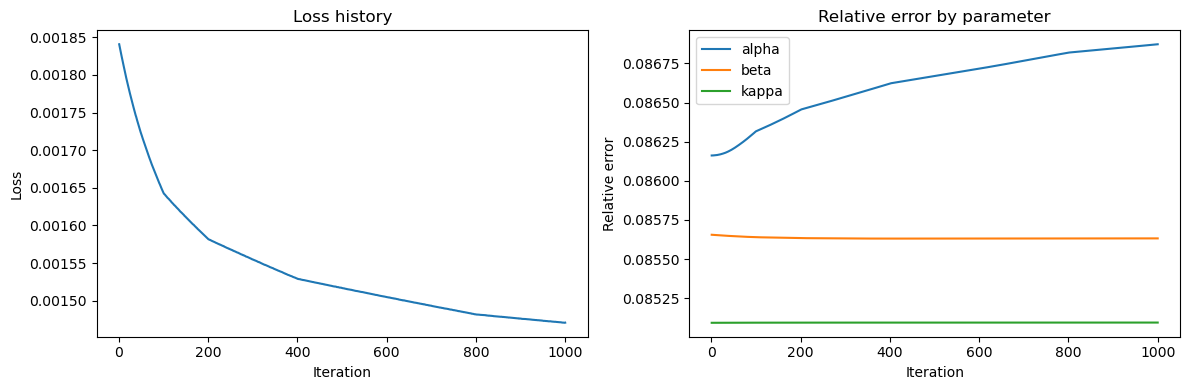

In [ ]:
# all labels together
history_df, stats, fig = analyze_inverse_results(os.getcwd(), prefix="hetero_cone_inverse")
plt.show()


---

## Material Parameter Training Results Comparison

Compare ground truth vs optimized parameters across x, y, z slices.

- **Row 1**: Ground truth (GT) parameters
- **Row 2**: Optimized/calculated results
- **Row 3**: Relative error |result - GT| / GT


In [ ]:
def load_parameter_comparison_data(fem_npz_path: Path, result_path: Path):
    """Load FEM ground truth and optimized parameter data."""
    # Load FEM ground truth from NPZ
    fem_data = np.load(fem_npz_path)
    points = fem_data['initial_pos'].astype(np.float64)
    cells = fem_data['tets'].astype(np.int32)
    labels = fem_data['labels'].astype(np.int32)
    
    # FEM ground truth: mu (shear modulus), lambda (volumetric)
    mu_cells = fem_data['mu_cells'].astype(np.float64)
    lambda_cells = fem_data['lambda_cells'].astype(np.float64)
    
    param_gt = {
        'alpha': mu_cells,
        'beta': mu_cells,
        'kappa': lambda_cells,
    }
    
    # Load optimized results
    result_mesh = meshio.read(result_path)
    param_result = {}
    param_names = []
    
    for name in result_mesh.cell_data.keys():
        if name != 'labels' and name in param_gt:
            param_result[name] = np.asarray(result_mesh.cell_data[name][0]).astype(np.float64)
            param_names.append(name)
    
    print(f"Loaded: {points.shape[0]} nodes, {cells.shape[0]} tets")
    print(f"Parameters: {param_names}")
    
    return points, cells, labels, param_gt, param_result, param_names


def render_parameter_comparison(
    layer_index: int, slices: int, param_name: str, label_value,
    points, cells, labels, param_gt, param_result
):
    """Render 3x3 comparison: GT, Result, Error."""
    centroids = points[cells].mean(axis=1)
    gt_values = param_gt[param_name]
    result_values = param_result[param_name]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_error = np.abs((result_values - gt_values) / gt_values)
        rel_error[~np.isfinite(rel_error)] = 0.0
    
    fig, axes = plt.subplots(3, 3, figsize=(24, 20), constrained_layout=True)
    
    axes_info = [
        {"name": "x", "axis_idx": 0, "plane_indices": (1, 2), "plane_labels": ("y", "z")},
        {"name": "y", "axis_idx": 1, "plane_indices": (0, 2), "plane_labels": ("x", "z")},
        {"name": "z", "axis_idx": 2, "plane_indices": (0, 1), "plane_labels": ("x", "y")},
    ]
    
    slices = max(int(slices), 1)
    layer_index = int(np.clip(layer_index, 0, slices - 1))
    
    row_labels = ["Ground Truth (FEM)", "Optimized Result", "Relative Error"]
    row_data = [gt_values, result_values, rel_error]
    row_cmaps = ["viridis", "viridis", "hot"]
    
    vmin_param = min(gt_values.min(), result_values.min())
    vmax_param = max(gt_values.max(), result_values.max())
    vmin_error = 0.0
    vmax_error = rel_error.max()
    
    for col_idx, info in enumerate(axes_info):
        axis_idx = info["axis_idx"]
        plane_i, plane_j = info["plane_indices"]
        
        coords = centroids[:, axis_idx]
        coord_min, coord_max = float(coords.min()), float(coords.max())
        edges = np.linspace(coord_min, coord_max, slices + 1)
        lower, upper = edges[layer_index], edges[layer_index + 1]
        
        mask = (coords >= lower) & (coords < upper)
        if label_value != "all" and labels is not None:
            mask &= labels == int(label_value)
        
        tet_ids = np.where(mask)[0]
        
        for row_idx in range(3):
            ax = axes[row_idx, col_idx]
            
            if tet_ids.size == 0:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_axis_off()
                continue
            
            projected = points[:, [plane_i, plane_j]]
            faces = np.array([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]], dtype=int)
            triangles = []
            tri_values = []
            
            values = row_data[row_idx]
            for tet_idx in tet_ids:
                nodes = cells[tet_idx]
                value = values[tet_idx]
                for face in faces:
                    triangles.append(nodes[face])
                    tri_values.append(value)
            
            triang = mtri.Triangulation(
                projected[:, 0], projected[:, 1],
                np.asarray(triangles, dtype=int),
            )
            
            if row_idx < 2:
                vmin, vmax = vmin_param, vmax_param
            else:
                vmin, vmax = vmin_error, vmax_error
            
            collection = ax.tripcolor(
                triang, facecolors=np.asarray(tri_values, dtype=float),
                cmap=row_cmaps[row_idx], shading="flat",
                vmin=vmin, vmax=vmax,
            )
            
            ax.set_xlabel(info["plane_labels"][0], fontsize=10)
            ax.set_ylabel(info["plane_labels"][1], fontsize=10)
            ax.set_aspect("equal", adjustable="box")
            
            if col_idx == 1:
                title = f"{row_labels[row_idx]}\n{info['name']}-slice {layer_index + 1}/{slices}"
            else:
                title = f"{info['name']}-slice {layer_index + 1}/{slices}"
            ax.set_title(title, fontsize=11)
            
            if row_idx == 0 or row_idx == 2:
                cbar = fig.colorbar(collection, ax=ax, fraction=0.046, pad=0.04)
                if row_idx < 2:
                    cbar.set_label(param_name, fontsize=9)
                else:
                    cbar.set_label("Rel. Error", fontsize=9)
            
            slice_vals = np.array(tri_values)
            stats_text = f"min={slice_vals.min():.3e}\nmean={slice_vals.mean():.3e}\nmax={slice_vals.max():.3e}"
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    fig.suptitle(f"{param_name.capitalize()} - Comparison", 
                fontsize=16, fontweight='bold')
    display(fig)
    plt.close(fig)


def create_parameter_comparison_viewer(fem_npz_path: Path, result_path: Path):
    """Create interactive parameter comparison viewer."""
    points, cells, labels, param_gt, param_result, param_names = load_parameter_comparison_data(
        fem_npz_path, result_path
    )
    
    slice_count_widget = widgets.IntSlider(value=20, min=5, max=120, step=1, description="Slices")
    layer_index_widget = widgets.IntSlider(value=10, min=0, max=39, step=1, description="Layer")
    param_widget = widgets.Dropdown(options=param_names, value=param_names[0], description="Parameter")
    
    label_options = [("All labels", "all")]
    if labels is not None:
        label_options += [(f"Label {int(val)}", int(val)) for val in np.unique(labels)]
    label_widget = widgets.Dropdown(options=label_options, value="all", description="Label")
    
    def update_layer_range(*args):
        layer_index_widget.max = slice_count_widget.value - 1
        layer_index_widget.value = min(layer_index_widget.value, layer_index_widget.max)
    
    slice_count_widget.observe(update_layer_range, 'value')
    
    controls = widgets.VBox([
        widgets.HBox([param_widget, label_widget]),
        widgets.HBox([slice_count_widget, layer_index_widget]),
    ])
    
    output = widgets.interactive_output(
        render_parameter_comparison,
        {
            "layer_index": layer_index_widget,
            "slices": slice_count_widget,
            "param_name": param_widget,
            "label_value": label_widget,
            "points": widgets.fixed(points),
            "cells": widgets.fixed(cells),
            "labels": widgets.fixed(labels),
            "param_gt": widgets.fixed(param_gt),
            "param_result": widgets.fixed(param_result),
        },
    )
    
    display(controls, output)


In [ ]:
# FEM GT vs Optimized Results
fem_npz_path = Path("cone_data/cone_fem_droop.npz")
result_path = Path("results/xdmf_visualization/cone_sms_inverse_final_params.xdmf")

create_parameter_comparison_viewer(fem_npz_path, result_path)


Loaded: 1829 nodes, 8070 tets
Parameters: ['alpha']


Output()

---

## Optimization Convergence Analysis

Analyze parameter optimization history and convergence behavior.


In [ ]:
# Compare different labels
# Analyze changes for specific labels
base_dir = Path(os.getcwd())
changes_path = base_dir / "inv_his_records" / "hetero_cone_inverse_parameter_changes.npz"

# Load to check available labels
changes_data = np.load(changes_path)
unique_labels = np.unique(changes_data["labels"])
print(f"Available labels: {unique_labels}")

# Analyze each label separately
for label in unique_labels:
    stats = analyze_parameter_changes(changes_path, label_value=label)
    print_parameter_stats(stats, label_value=label)


Available labels: [0 1]

=== Parameter Change Statistics (Label 0) ===
alpha  change: min=-142.781860, mean= -4.443380, max=125.653931, std= 25.114435
beta   change: min=-114.416504, mean= -0.164930, max= 94.446289, std= 10.540019
kappa  change: min=-29.555664, mean= -0.163410, max= 11.583984, std=  1.500353

=== Parameter Change Statistics (Label 1) ===
alpha  change: min=-46.832764, mean= -6.320281, max= 40.151001, std= 13.095821
beta   change: min= -7.559082, mean= -1.622104, max=  8.135742, std=  2.620484
kappa  change: min= -2.086914, mean= -0.125460, max=  1.429688, std=  0.456199


In [ ]:
# Print relative error statistics for each label (final values from parameter changes)
base_dir = Path(os.getcwd())
changes_path = base_dir / "inv_his_records" / "hetero_cone_inverse_parameter_changes.npz"

changes_data = np.load(changes_path)

if "labels" in changes_data:
    labels = changes_data["labels"]
    unique_labels = np.unique(labels)
    
    print("=== Final Relative Error by Label ===\n")
    
    for label in unique_labels:
        mask = labels == label
        print(f"Label {int(label)}:")
        
        for param in ["alpha", "beta", "kappa"]:
            change = changes_data[f"{param}_change"][mask]
            mean_rel_error = float(np.abs(change).mean())
            print(f"  {param:6s}: mean_rel_error = {mean_rel_error:.6f}")
        
        print()
else:
    print("No label information found in the data.")


=== Final Relative Error by Label ===

Label 0:
  alpha : mean_rel_error = 13.646315
  beta  : mean_rel_error = 4.052310
  kappa : mean_rel_error = 0.508774

Label 1:
  alpha : mean_rel_error = 10.926318
  beta  : mean_rel_error = 2.615363
  kappa : mean_rel_error = 0.304612



In [ ]:
# Print comparison table of relative errors across labels
changes_data = np.load(changes_path)

if "labels" in changes_data:
    labels = changes_data["labels"]
    unique_labels = np.unique(labels)
    
    params = ["alpha", "beta", "kappa"]
    
    # Compute stats
    print("=== Relative Error Comparison Across Labels ===\n")
    print(f"{'Label':<10} {'Alpha':<15} {'Beta':<15} {'Kappa':<15}")
    print("-" * 55)
    
    for label in unique_labels:
        mask = labels == label
        values = []
        for param in params:
            change = changes_data[f"{param}_change"][mask]
            mean_rel_error = float(np.abs(change).mean())
            values.append(f"{mean_rel_error:.6f}")
        
        print(f"{int(label):<10} {values[0]:<15} {values[1]:<15} {values[2]:<15}")
else:
    print("No label information found in the data.")


=== Relative Error Comparison Across Labels ===

Label      Alpha           Beta            Kappa          
-------------------------------------------------------
0          13.646315       4.052310        0.508774       
1          10.926318       2.615363        0.304612       


## Relative Error Convergence by Label

Visualize how the relative error changes over iterations for each label.

In [ ]:
# Load iteration history with per-label statistics
base_dir = Path(os.getcwd())
history_path = base_dir / "inv_his_records" / "hetero_cone_inverse_history.jsonl"

# Load true parameter values from FEM ground truth
fem_data = np.load(base_dir / "cone_data" / "cone_fem_droop.npz")
mu_cells = fem_data['mu_cells']
lambda_cells = fem_data['lambda_cells']
labels = fem_data['labels']
unique_labels = np.unique(labels)

# Compute true parameters for each label (average)
true_params = {}
for label_val in unique_labels:
    mask = labels == label_val
    label_name = 'background' if label_val == 0 else 'special'
    true_params[label_name] = {
        'alpha': float(mu_cells[mask].mean()),
        'beta': float(mu_cells[mask].mean()),
        'kappa': float(lambda_cells[mask].mean()),
    }

print(f"True parameters loaded from FEM:")
for label_name, params in true_params.items():
    print(f"  {label_name}: alpha={params['alpha']:.2f}, beta={params['beta']:.2f}, kappa={params['kappa']:.2f}")

# Load iteration history
overall_df, label_dfs = load_iteration_history_with_labels(history_path)
print(f"\nLoaded history for {len(label_dfs)} labels: {list(label_dfs.keys())}")

# Compute relative errors for each label against true values
label_relative_errors = compute_label_relative_errors(label_dfs, true_params)


True parameters loaded from FEM:
  background: alpha=3569.41, beta=3569.41, kappa=14277.64
  special: alpha=5361.72, beta=5361.72, kappa=21446.86

Loaded history for 2 labels: ['background', 'special']


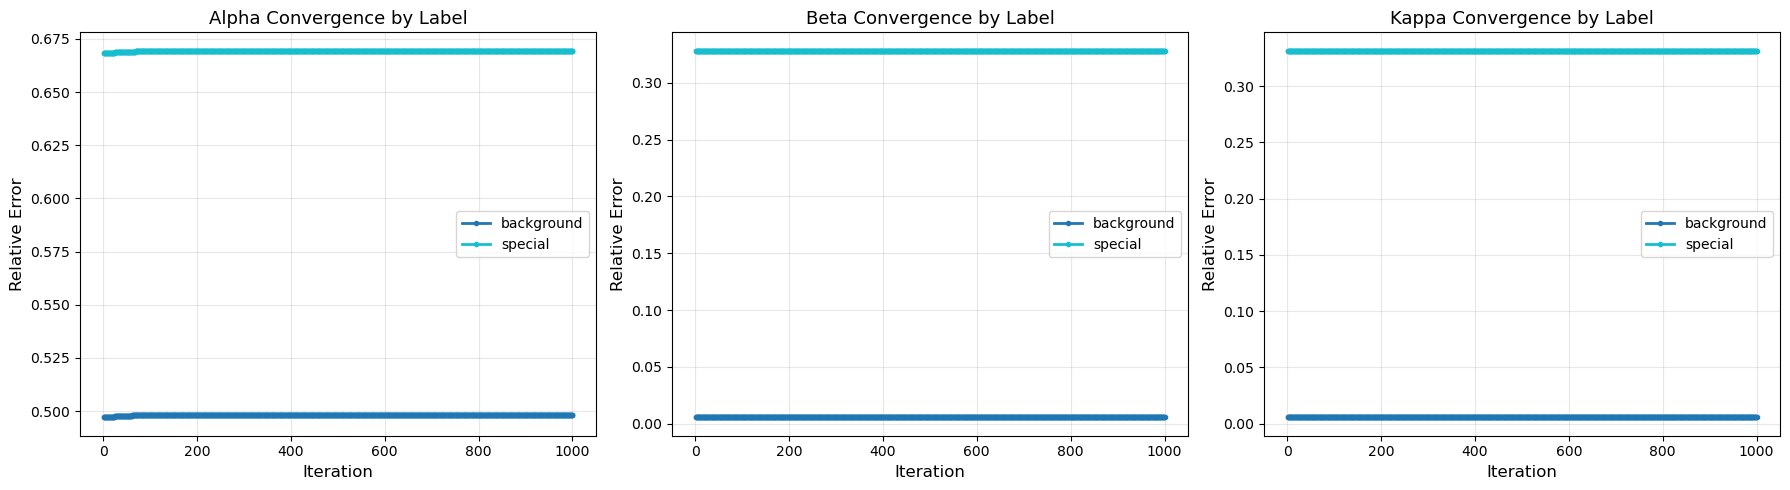

: 

In [ ]:
# Plot all labels comparison - all parameters on separate subplots
fig = plot_all_labels_comparison(label_relative_errors, params=["alpha", "beta", "kappa"])
plt.show()